# Q1: The stock market

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import mpmath as mp
from numba import njit
import multiprocessing, pathos.multiprocessing
from tqdm.notebook import tqdm

def stock_market(days:int, n_sample:int=1) -> np.ndarray:
    # Bull = 0
    # Bear = 1
    # Stagnant = 2
    tm = np.array([[0.9, 0.9075, 1], [0.15, 0.95, 1], [0.25, 0.50, 1]])
    state = np.zeros((n_sample, days+1), dtype = np.int64)
    for s in range(n_sample):
        state[s, 0] = np.random.randint(0, 3)
        n = np.random.random(days)
        for d in range(1, days+1):
            for i in range(3):
                if n[d-1] < tm[state[s, d-1], i]:
                    state[s, d] = i
                    break
    
    return state

In [2]:
start = time.time()
my_market = stock_market(365, 100000)
print(f"Time of execution: {time.time() - start}")
prob_per_day = {"Bull market": np.mean(my_market == 0, axis = 0),
                "Bear market": np.mean(my_market == 1, axis = 0),
                "Stagnant market": np.mean(my_market == 2, axis = 0)}

Time of execution: 34.00837969779968


In [3]:
c_stock_market = njit(stock_market)

start = time.time()
my_market = c_stock_market(365, 100000)
print(f"Time of execution: {time.time() - start}")

prob_per_day = {"Bull market": np.mean(my_market == 0, axis = 0),
                "Bear market": np.mean(my_market == 1, axis = 0),
                "Stagnant market": np.mean(my_market == 2, axis = 0)}

Time of execution: 2.8514552116394043


Text(0.5, 1.0, 'Probability to be in a given state vs days')

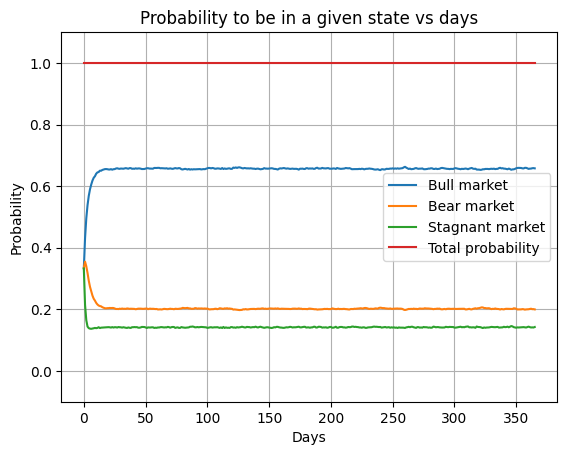

In [4]:
plt.plot(np.arange(0, 366), prob_per_day["Bull market"], label = "Bull market")
plt.plot(np.arange(0, 366), prob_per_day["Bear market"], label = "Bear market")
plt.plot(np.arange(0, 366), prob_per_day["Stagnant market"], label = "Stagnant market")
plt.plot(np.arange(0, 366), prob_per_day["Stagnant market"] + prob_per_day["Bear market"] + prob_per_day["Bull market"], label = "Total probability")
plt.legend()
plt.grid()
plt.ylim(-0.1, 1.1)
plt.xlabel("Days")
plt.ylabel("Probability")
plt.title("Probability to be in a given state vs days")

As we can see from the plot, since this is a Markov chain, there is a termalization time, and then the probability distribution set to the stationary distribution.

# Q3: Scaling

In this exercise I will try to parallelize a small part of a computation of the reasearch I am working on, which consist in the repeated evaluation of a function defined as an integral, which we need to compute in arbitrary precision due to the nasty integrand function.

In [12]:
M_pi = 270*0.065/197.3 #Pion mass for the lattice considered
w0, sigma = 4*M_pi, M_pi
s = np.linspace(20, 80, 64)

def v_s_mp(s:float, w:float):
        a1 = mp.mpc('1/2', str(s))
        a2 = mp.mpc('3/2', str(s))
        lambda_s = mp.gamma(a1)
        N_s = mp.sqrt(mp.mpf('2') * mp.pi) * \
            mp.gamma(mp.mpc('0', mp.mpf('-2') * mp.mpf(str(s))))/mp.gamma(mp.mpc('3/2', mp.mpf(str(-s))))
        z = mp.exp(-mp.mpf(str(w)))
        return (mp.hyp2f1(a1, a2, mp.mpf('2'), z, maxterms=100000) * (1-z)**(mp.mpc('-1/2', str(s))) * z * mp.fabs(lambda_s) / mp.fabs(N_s)).real 

def f(s):
    return mp.quad(lambda w: v_s_mp(s, w) * mp.exp(-(w-w0)**2/(2* sigma**2))/mp.sqrt(2*mp.pi* sigma**2), [0, +mp.inf], maxdegree=12, error=True)


In [13]:
multiprocessing.cpu_count()

8

In [15]:
CPUS = [1, 2, 4, 8, 16, 32]

times = []
for nc in CPUS:
    print(f"Cores used: {nc}")
    parmap = pathos.multiprocessing.ProcessingPool(nc).imap
    start = time.time()
    list(tqdm(parmap(f, s), total = len(s)))
    times.append(time.time() - start)

Cores used:1


  0%|          | 0/64 [00:00<?, ?it/s]

Cores used:2


  0%|          | 0/64 [00:00<?, ?it/s]

Cores used:4


  0%|          | 0/64 [00:00<?, ?it/s]

Cores used:8


  0%|          | 0/64 [00:00<?, ?it/s]

Cores used:16


  0%|          | 0/64 [00:00<?, ?it/s]

Cores used:32


  0%|          | 0/64 [00:00<?, ?it/s]

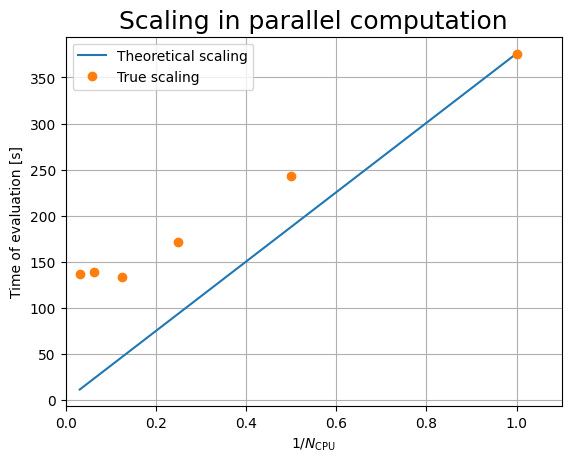

In [38]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(1/np.linspace(1, 32, 101), times[0]/np.linspace(1, 32, 101), label = "Theoretical scaling")
ax.plot(1/np.array(CPUS), times, "o", label="True scaling")
ax.grid(True)
ax.xaxis.set_label_text(r"$1/N_\mathrm{CPU}$")
ax.yaxis.set_label_text("Time of evaluation [s]")
ax.set_xlim(0, 1.1)
ax.set_title("Scaling in parallel computation", fontsize = 18)
ax.legend()

As we can see, the scaling is pretty linear for $N_\mathrm{CPU}=1,2,4,8$ (although it does not manage to follow the theoretical scaling given by $O(1/p)$, $p$ number of processes), but then for 16 processes we have 2 processes per core (which share the CPU time), and analogously for 32 processes, effectively reaching a plateau in the performance. Good to know for my research!